In [1]:
import torch
import copy
from torchvision import models
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import optim
from torch import nn
from torch.nn import functional as F
 
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
train_dataset = datasets.MNIST(root='MNIST_data/', train = True, transform = transforms.ToTensor(), download = True)
test_dataset = datasets.MNIST(root='MNIST_data/', train = False, transform = transforms.ToTensor(), download = True)

C:\Users\WorkStation\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
def make_dir(args):    
    import os

    MODEL_DIR1 = f"FL_model/client = {args.num_clients}"
    MODEL_DIR2 = f"Final/parameter_data"
    try:
        os.makedirs(MODEL_DIR1)
        os.makedirs(MODEL_DIR2)
    except FileExistsError:
        print('Directories not created because they already exist')

In [6]:
def list_np_tensor(param_data):
    data = []
    for i in range(np.size(param_data, 0)):
        data.append(np.concatenate((param_data[i]['net.0.weight'].cpu().numpy(), np.expand_dims(param_data[i]['net.0.bias'].cpu().numpy(), axis=1)),axis=1))
    
    data = torch.Tensor(data)
    return data
    
def save_param(param_data):
    dt = list_np_tensor(param_data)
    dt = dt.view(args.num_clients*args.num_rounds, -1)
    dtf = pd.DataFrame(dt)
    dtf.to_csv(f"Final/parameter_data/param_data_{args.num_clients}.csv")
    print('finished save')

def save_param_with_round(param_data, round_list, args):
    dt = list_np_tensor(param_data)
    dt = dt.view(args.num_clients*args.num_rounds, -1)
    
    round_tensor = torch.tensor(round_list).view(-1, 1)
    dt_r = torch.cat((dt, round_tensor), dim=1)
    
    dtf = pd.DataFrame(dt_r)
    dtf.to_csv(f"Final/parameter_data/param_data_{args.num_clients}.csv")
    print('finished save')

def load_data(args):    
    ldt = pd.read_csv(f"Final/parameter_data/param_data_{args.num_clients}.csv")
    ldt = ldt.values
    ldt = np.delete(ldt, 0, 1)
    return ldt

def data_split(args):
    dataset_list=[]

    num_data_arr = np.ones((args.num_clients,), dtype=int) * int(len(train_dataset)/args.num_clients)
    dataset_list = torch.utils.data.random_split(train_dataset, num_data_arr)
    return dataset_list

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = nn.Sequential(nn.Linear(28*28, 10)
                                )

    def forward(self, x):
        x = x.view(-1,28*28)
        out = self.net(x)
        return out

In [8]:
def train(net, train_loader, criterion, optimizer, args):

    for epoch in range(args.num_epochs):        
        for images, labels in iter(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad() 
            
            outputs = net(images)  
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

    torch.save(net, args.NET_PATH)
    return net

In [9]:
def Fed_AVG(model, client_model_list, args):
    model.train()
    local_weights = []

    for i in range(args.num_clients):
        local_weights.append(copy.deepcopy(client_model_list[i].state_dict()))
    w_avg = copy.deepcopy(local_weights[0]) #type of w_avg : <class 'collections.OrderedDict'>

    for key in w_avg.keys():
        for i in range(1,len(local_weights)):
            w_avg[key] += local_weights[i][key]

        w_avg[key] = torch.div(w_avg[key], len(local_weights))

    global_weights = w_avg
    model.load_state_dict(global_weights)
    torch.save(model, args.INIT_PATH)

    return model, local_weights

In [10]:
def test(model, partition, criterion, args):
    test_loader = DataLoader(partition['test'], batch_size=args.batch_size, shuffle=True)
    model.eval()
        
    correct = 0 # 정답을 맞힌 이미지 개수
    total = 0 # 전체 이미지 개수
    loss = 0
    round_accuracy = 0
    round_loss = 0

    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)
    
    round_loss = loss / len(test_loader)
    round_accuracy = (correct / total) * 100.0
    
    return round_loss, round_accuracy

In [11]:
def define_client(partition, r, num, args):
    train_loader = DataLoader(partition['train'][num], batch_size=args.batch_size, shuffle=True)
    
    if r == 0:
        net = Net().to(device)
    else:
        net = torch.load(args.INIT_PATH)
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=0.8)

    return net, train_loader, criterion, optimizer

In [12]:
def experiment(partition, args):
    model = Net().to(device)
    torch.save(model, args.INIT_PATH)

    round_losses = []
    round_acces = []
    param_data = []
    round_list = []

    for r in range(args.num_rounds):
        client_model_list = []
        
        for num in range(args.num_clients):
            if args.exp_name == 'final':
                setattr(args, 'NET_PATH', f'Final/client_{num}.pth')
            else:
                setattr(args, 'NET_PATH', f'FL_model/client = {args.num_clients}/client_{num}.pth')
            
            net, train_loader, criterion, optimizer = define_client(partition, r, num, args)
            net = train(net, train_loader, criterion, optimizer, args)
            client_model_list.append(net)

        model, local_weights = Fed_AVG(model, client_model_list, args)
        round_loss, round_acc = test(model, partition, criterion, args)

        print(f'[Round {r}]  Round Loss: {round_loss}  Round Acc: {round_acc:.2f}')

        round_losses.append(round_loss)
        round_acces.append(round_acc)
        round_list.append([r, r, r])
        param_data += local_weights
        
    return round_losses, round_acces, round_list, param_data

In [13]:
def plot_loss(round_loss, round_acc):
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1,2,1)
    plt.plot(round_loss, label = 'Loss')
    plt.xlabel('Rounds')
    plt.grid()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(round_acc, label = 'Accuracy')
    plt.xlabel('Rounds')
    plt.grid()
    plt.legend()

    plt.show()

### **Example 1 : *lr***

lr:0.0007
[Round 0]  Round Loss: 0.9070182675123215  Round Acc: 83.89
[Round 1]  Round Loss: 0.6717093634605408  Round Acc: 85.96
[Round 2]  Round Loss: 0.5752537044882774  Round Acc: 87.24
[Round 3]  Round Loss: 0.5211259555816651  Round Acc: 87.87
[Round 4]  Round Loss: 0.4857627010345459  Round Acc: 88.29
[Round 5]  Round Loss: 0.4605639311671257  Round Acc: 88.62
[Round 6]  Round Loss: 0.44145152509212493  Round Acc: 88.92
[Round 7]  Round Loss: 0.42639091521501543  Round Acc: 89.19
[Round 8]  Round Loss: 0.41413271486759184  Round Acc: 89.38
[Round 9]  Round Loss: 0.40392217829823496  Round Acc: 89.50
[Round 10]  Round Loss: 0.39523598179221153  Round Acc: 89.69
[Round 11]  Round Loss: 0.38771243959665297  Round Acc: 89.88
[Round 12]  Round Loss: 0.3812220759689808  Round Acc: 90.05
[Round 13]  Round Loss: 0.3754506552219391  Round Acc: 90.11
[Round 14]  Round Loss: 0.37025799095630646  Round Acc: 90.19
[Round 15]  Round Loss: 0.3656893181800842  Round Acc: 90.24
[Round 16]  Round

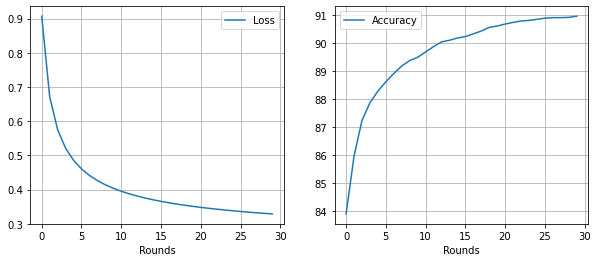

lr:0.001
[Round 0]  Round Loss: 0.7744768035411834  Round Acc: 85.13
[Round 1]  Round Loss: 0.58615065574646  Round Acc: 87.00
[Round 2]  Round Loss: 0.5102128046751022  Round Acc: 87.92
[Round 3]  Round Loss: 0.46753587007522585  Round Acc: 88.43
[Round 4]  Round Loss: 0.4395195960998535  Round Acc: 88.82
[Round 5]  Round Loss: 0.41952783733606336  Round Acc: 89.17
[Round 6]  Round Loss: 0.40424011543393135  Round Acc: 89.47
[Round 7]  Round Loss: 0.39225578799843785  Round Acc: 89.80
[Round 8]  Round Loss: 0.3824134510755539  Round Acc: 89.96
[Round 9]  Round Loss: 0.3741821098327637  Round Acc: 90.08
[Round 10]  Round Loss: 0.367156093865633  Round Acc: 90.17
[Round 11]  Round Loss: 0.3611362265050411  Round Acc: 90.32
[Round 12]  Round Loss: 0.35589039608836176  Round Acc: 90.49
[Round 13]  Round Loss: 0.3511719450354576  Round Acc: 90.64
[Round 14]  Round Loss: 0.3470097044110298  Round Acc: 90.69
[Round 15]  Round Loss: 0.34325935259461404  Round Acc: 90.76
[Round 16]  Round Loss

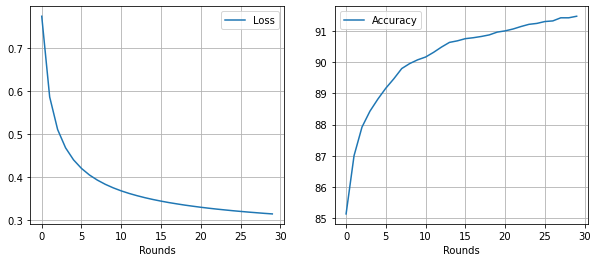

lr:0.004
[Round 0]  Round Loss: 0.4666477200388908  Round Acc: 88.45
[Round 1]  Round Loss: 0.39208524256944655  Round Acc: 89.71
[Round 2]  Round Loss: 0.3612371228635311  Round Acc: 90.29
[Round 3]  Round Loss: 0.3438547097146511  Round Acc: 90.69
[Round 4]  Round Loss: 0.33146433264017106  Round Acc: 90.95
[Round 5]  Round Loss: 0.32260061249136923  Round Acc: 91.17
[Round 6]  Round Loss: 0.3165236143767834  Round Acc: 91.38
[Round 7]  Round Loss: 0.3108815287053585  Round Acc: 91.52
[Round 8]  Round Loss: 0.30675869271159173  Round Acc: 91.62
[Round 9]  Round Loss: 0.3031544947624207  Round Acc: 91.65
[Round 10]  Round Loss: 0.30011888802051545  Round Acc: 91.73
[Round 11]  Round Loss: 0.29754913434386254  Round Acc: 91.76
[Round 12]  Round Loss: 0.2953857757151127  Round Acc: 91.77
[Round 13]  Round Loss: 0.29349538654088975  Round Acc: 91.81
[Round 14]  Round Loss: 0.29176551461219785  Round Acc: 91.95
[Round 15]  Round Loss: 0.29011147931218145  Round Acc: 91.99
[Round 16]  Roun

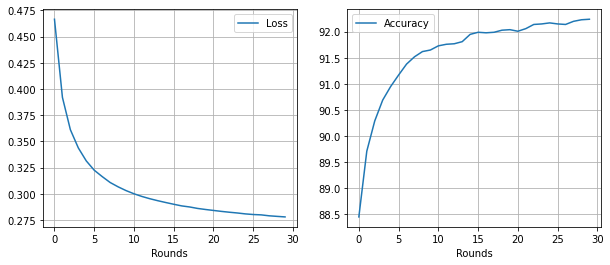

lr:0.007
[Round 0]  Round Loss: 0.40367141991853717  Round Acc: 89.52
[Round 1]  Round Loss: 0.35114573553204537  Round Acc: 90.61
[Round 2]  Round Loss: 0.32898385003209113  Round Acc: 91.03
[Round 3]  Round Loss: 0.3163174380362034  Round Acc: 91.39
[Round 4]  Round Loss: 0.3076765306293964  Round Acc: 91.63
[Round 5]  Round Loss: 0.3017351435124874  Round Acc: 91.64
[Round 6]  Round Loss: 0.2968201243877411  Round Acc: 91.77
[Round 7]  Round Loss: 0.29346529364585877  Round Acc: 91.91
[Round 8]  Round Loss: 0.29064874082803727  Round Acc: 91.94
[Round 9]  Round Loss: 0.28821304433047773  Round Acc: 91.95
[Round 10]  Round Loss: 0.28617980137467386  Round Acc: 92.02
[Round 11]  Round Loss: 0.28402653902769087  Round Acc: 92.08
[Round 12]  Round Loss: 0.2826746052503586  Round Acc: 92.11
[Round 13]  Round Loss: 0.2812137649953365  Round Acc: 92.19
[Round 14]  Round Loss: 0.2803875247389078  Round Acc: 92.16
[Round 15]  Round Loss: 0.2791856832802296  Round Acc: 92.23
[Round 16]  Round

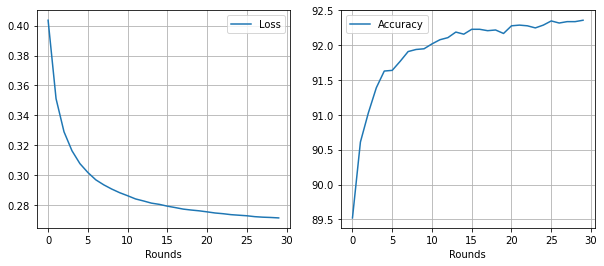

lr:0.01
[Round 0]  Round Loss: 0.3735876747965813  Round Acc: 90.10
[Round 1]  Round Loss: 0.33103999435901643  Round Acc: 91.03
[Round 2]  Round Loss: 0.3131403222680092  Round Acc: 91.43
[Round 3]  Round Loss: 0.3029401087760925  Round Acc: 91.62
[Round 4]  Round Loss: 0.29608974650502207  Round Acc: 91.72
[Round 5]  Round Loss: 0.2916018828749657  Round Acc: 91.86
[Round 6]  Round Loss: 0.2876462659239769  Round Acc: 91.96
[Round 7]  Round Loss: 0.2854230862855911  Round Acc: 92.02
[Round 8]  Round Loss: 0.2831163653731346  Round Acc: 92.04
[Round 9]  Round Loss: 0.2809120634198189  Round Acc: 92.14
[Round 10]  Round Loss: 0.2793462088704109  Round Acc: 92.18
[Round 11]  Round Loss: 0.2782129855453968  Round Acc: 92.27
[Round 12]  Round Loss: 0.27691903881728647  Round Acc: 92.23
[Round 13]  Round Loss: 0.2757783767580986  Round Acc: 92.23
[Round 14]  Round Loss: 0.27494968481361864  Round Acc: 92.29
[Round 15]  Round Loss: 0.27407185435295106  Round Acc: 92.18
[Round 16]  Round Los

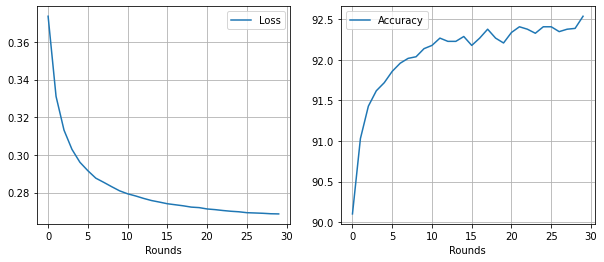

best set of exp1:  [92.54, 0.01]


In [12]:
seed = 1228
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

args.exp_name = 'exp1'

args.num_epochs = 5
args.num_rounds = 30
args.num_clients = 3
args.lr = 0.002

args.batch_size = 100

args.NET_PATH = ''
args.INIT_PATH = f'FL_model/client = {args.num_clients}/initialize_weight.pth'



name_var = 'lr'
list_var = [0.0007, 0.001, 0.004, 0.007, 0.01]
exp1_best_set = [0, 0]

train_set_list = data_split(args)
partition = {'train':train_set_list, 'test':test_dataset}

for var in list_var:
    setattr(args, name_var, var)

    print(f"{name_var}:{var}")
    
    round_loss, round_acc, round_list, param_data = experiment(partition, args)
    plot_loss(round_loss, round_acc)

    if max(round_acc) > exp1_best_set[0]:
        exp1_best_set[0] = max(round_acc)
        exp1_best_set[1] = var

print('best set of exp1: ', exp1_best_set)

### **Example 2 : *epochs vs rounds***

num_epochs:3 | num_rounds:10
[Round 0]  Round Loss: 0.41807751446962355  Round Acc: 89.31
[Round 1]  Round Loss: 0.3603855603933334  Round Acc: 90.47
[Round 2]  Round Loss: 0.33700832188129426  Round Acc: 90.87
[Round 3]  Round Loss: 0.3227891713380814  Round Acc: 91.23
[Round 4]  Round Loss: 0.31325348511338236  Round Acc: 91.48
[Round 5]  Round Loss: 0.3068219123035669  Round Acc: 91.55
[Round 6]  Round Loss: 0.3020238135010004  Round Acc: 91.55
[Round 7]  Round Loss: 0.2975462806224823  Round Acc: 91.79
[Round 8]  Round Loss: 0.29450838729739187  Round Acc: 91.89
[Round 9]  Round Loss: 0.2919898219406605  Round Acc: 91.81


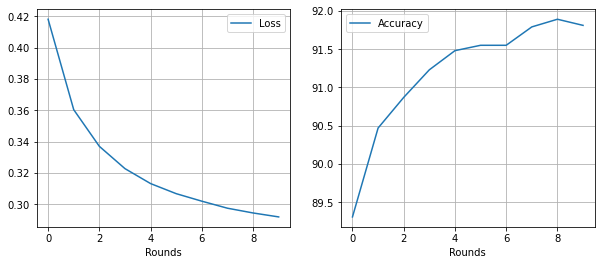

num_epochs:3 | num_rounds:15
[Round 0]  Round Loss: 0.4184515956044197  Round Acc: 89.29
[Round 1]  Round Loss: 0.360324380248785  Round Acc: 90.41
[Round 2]  Round Loss: 0.3362557126581669  Round Acc: 90.85
[Round 3]  Round Loss: 0.3222709593176842  Round Acc: 91.16
[Round 4]  Round Loss: 0.3132639256119728  Round Acc: 91.44
[Round 5]  Round Loss: 0.30636337265372277  Round Acc: 91.59
[Round 6]  Round Loss: 0.3015464414656162  Round Acc: 91.60
[Round 7]  Round Loss: 0.2972938102483749  Round Acc: 91.76
[Round 8]  Round Loss: 0.29428129963576793  Round Acc: 91.83
[Round 9]  Round Loss: 0.29189235597848895  Round Acc: 91.90
[Round 10]  Round Loss: 0.2891110387444496  Round Acc: 91.96
[Round 11]  Round Loss: 0.2872697139531374  Round Acc: 91.95
[Round 12]  Round Loss: 0.2853050954639912  Round Acc: 92.06
[Round 13]  Round Loss: 0.2838518911600113  Round Acc: 91.97
[Round 14]  Round Loss: 0.28276211604475976  Round Acc: 92.03


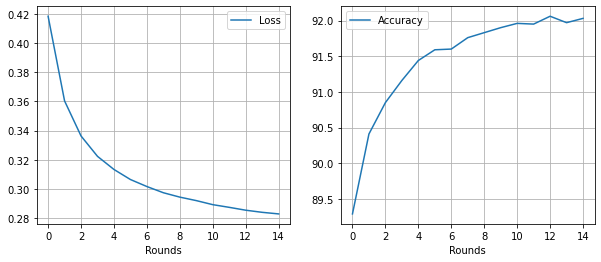

num_epochs:3 | num_rounds:20
[Round 0]  Round Loss: 0.41855599611997607  Round Acc: 89.25
[Round 1]  Round Loss: 0.36090659976005557  Round Acc: 90.29
[Round 2]  Round Loss: 0.3368235993385315  Round Acc: 90.79
[Round 3]  Round Loss: 0.32332494109869003  Round Acc: 91.12
[Round 4]  Round Loss: 0.3139248713850975  Round Acc: 91.39
[Round 5]  Round Loss: 0.3066588830947876  Round Acc: 91.60
[Round 6]  Round Loss: 0.30187969744205473  Round Acc: 91.69
[Round 7]  Round Loss: 0.29713947147130965  Round Acc: 91.77
[Round 8]  Round Loss: 0.294605453684926  Round Acc: 91.87
[Round 9]  Round Loss: 0.291610995978117  Round Acc: 91.88
[Round 10]  Round Loss: 0.28958695352077485  Round Acc: 91.92
[Round 11]  Round Loss: 0.2872717469930649  Round Acc: 92.06
[Round 12]  Round Loss: 0.28572183564305303  Round Acc: 92.02
[Round 13]  Round Loss: 0.2839394597709179  Round Acc: 92.06
[Round 14]  Round Loss: 0.2830717146396637  Round Acc: 92.00
[Round 15]  Round Loss: 0.2817072685807943  Round Acc: 92.11


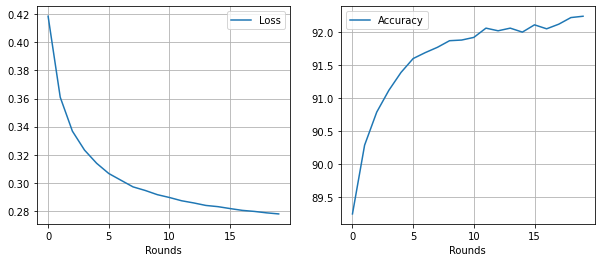

num_epochs:5 | num_rounds:10
[Round 0]  Round Loss: 0.3730930809676647  Round Acc: 90.12
[Round 1]  Round Loss: 0.33127252995967865  Round Acc: 90.91
[Round 2]  Round Loss: 0.31311202228069307  Round Acc: 91.48
[Round 3]  Round Loss: 0.3030902603268623  Round Acc: 91.66
[Round 4]  Round Loss: 0.29640083730220795  Round Acc: 91.77
[Round 5]  Round Loss: 0.29173062354326246  Round Acc: 91.90
[Round 6]  Round Loss: 0.28789322897791864  Round Acc: 91.98
[Round 7]  Round Loss: 0.2852455192804337  Round Acc: 92.02
[Round 8]  Round Loss: 0.28306655555963517  Round Acc: 92.03
[Round 9]  Round Loss: 0.28101339474320414  Round Acc: 92.11


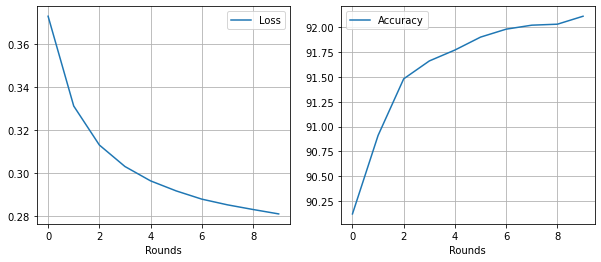

num_epochs:5 | num_rounds:15
[Round 0]  Round Loss: 0.37394234210252764  Round Acc: 90.04
[Round 1]  Round Loss: 0.3312695734202862  Round Acc: 91.01
[Round 2]  Round Loss: 0.31318512827157974  Round Acc: 91.54
[Round 3]  Round Loss: 0.30349664971232415  Round Acc: 91.67
[Round 4]  Round Loss: 0.29656401529908183  Round Acc: 91.90
[Round 5]  Round Loss: 0.29171419382095337  Round Acc: 91.93
[Round 6]  Round Loss: 0.2880759666860104  Round Acc: 92.01
[Round 7]  Round Loss: 0.28521300226449964  Round Acc: 92.08
[Round 8]  Round Loss: 0.2826967491209507  Round Acc: 92.16
[Round 9]  Round Loss: 0.2812249857187271  Round Acc: 92.11
[Round 10]  Round Loss: 0.2796160649508238  Round Acc: 92.21
[Round 11]  Round Loss: 0.2778186233341694  Round Acc: 92.29
[Round 12]  Round Loss: 0.2772552317380905  Round Acc: 92.26
[Round 13]  Round Loss: 0.2762988159060478  Round Acc: 92.23
[Round 14]  Round Loss: 0.27494378440082073  Round Acc: 92.26


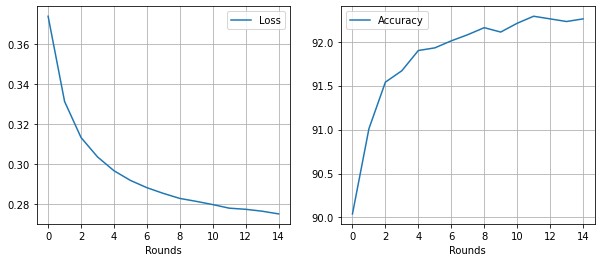

num_epochs:5 | num_rounds:20
[Round 0]  Round Loss: 0.3734883277118206  Round Acc: 90.07
[Round 1]  Round Loss: 0.3319595871865749  Round Acc: 90.84
[Round 2]  Round Loss: 0.3136447030305862  Round Acc: 91.36
[Round 3]  Round Loss: 0.30289173126220703  Round Acc: 91.72
[Round 4]  Round Loss: 0.2962171885371208  Round Acc: 91.83
[Round 5]  Round Loss: 0.29141361117362974  Round Acc: 91.89
[Round 6]  Round Loss: 0.28765867084264757  Round Acc: 92.02
[Round 7]  Round Loss: 0.2848740200698376  Round Acc: 92.08
[Round 8]  Round Loss: 0.2828229258954525  Round Acc: 92.01
[Round 9]  Round Loss: 0.2809729664027691  Round Acc: 92.13
[Round 10]  Round Loss: 0.2799231415241957  Round Acc: 92.21
[Round 11]  Round Loss: 0.27803289748728277  Round Acc: 92.17
[Round 12]  Round Loss: 0.27728318810462954  Round Acc: 92.27
[Round 13]  Round Loss: 0.27640467390418055  Round Acc: 92.24
[Round 14]  Round Loss: 0.27512981951236726  Round Acc: 92.30
[Round 15]  Round Loss: 0.2743004584312439  Round Acc: 92.2

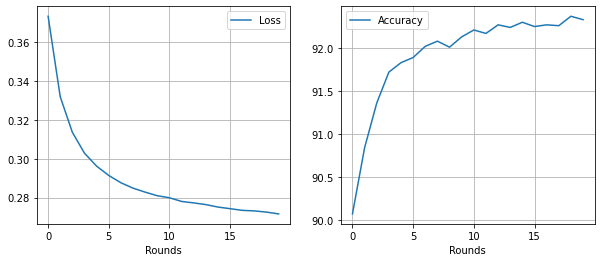

num_epochs:7 | num_rounds:10
[Round 0]  Round Loss: 0.3510190014541149  Round Acc: 90.61
[Round 1]  Round Loss: 0.31596825003623963  Round Acc: 91.26
[Round 2]  Round Loss: 0.30143625527620316  Round Acc: 91.64
[Round 3]  Round Loss: 0.29377673745155336  Round Acc: 91.83
[Round 4]  Round Loss: 0.28788812682032583  Round Acc: 92.01
[Round 5]  Round Loss: 0.2839457216858864  Round Acc: 92.13
[Round 6]  Round Loss: 0.2813410211354494  Round Acc: 92.20
[Round 7]  Round Loss: 0.27893780782818794  Round Acc: 92.19
[Round 8]  Round Loss: 0.27703783065080645  Round Acc: 92.26
[Round 9]  Round Loss: 0.27596387594938276  Round Acc: 92.29


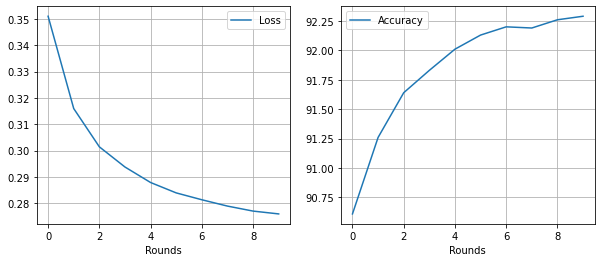

num_epochs:7 | num_rounds:15
[Round 0]  Round Loss: 0.3507631614804268  Round Acc: 90.53
[Round 1]  Round Loss: 0.3163636587560177  Round Acc: 91.33
[Round 2]  Round Loss: 0.3017431640625  Round Acc: 91.65
[Round 3]  Round Loss: 0.2934199348092079  Round Acc: 91.89
[Round 4]  Round Loss: 0.288427225202322  Round Acc: 92.01
[Round 5]  Round Loss: 0.2847202257812023  Round Acc: 92.00
[Round 6]  Round Loss: 0.28178886994719504  Round Acc: 92.08
[Round 7]  Round Loss: 0.2793281368911266  Round Acc: 92.18
[Round 8]  Round Loss: 0.2772293075174093  Round Acc: 92.24
[Round 9]  Round Loss: 0.27591351106762885  Round Acc: 92.24
[Round 10]  Round Loss: 0.27449266754090784  Round Acc: 92.24
[Round 11]  Round Loss: 0.2738517017662525  Round Acc: 92.20
[Round 12]  Round Loss: 0.2729970097541809  Round Acc: 92.31
[Round 13]  Round Loss: 0.2717737716436386  Round Acc: 92.33
[Round 14]  Round Loss: 0.2710572184622288  Round Acc: 92.34


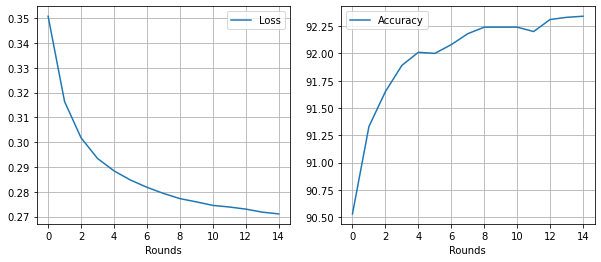

num_epochs:7 | num_rounds:20
[Round 0]  Round Loss: 0.35044840678572653  Round Acc: 90.49
[Round 1]  Round Loss: 0.31566441103816034  Round Acc: 91.43
[Round 2]  Round Loss: 0.30191567316651347  Round Acc: 91.68
[Round 3]  Round Loss: 0.2931855696439743  Round Acc: 91.96
[Round 4]  Round Loss: 0.2878349007666111  Round Acc: 91.96
[Round 5]  Round Loss: 0.28406775698065756  Round Acc: 92.06
[Round 6]  Round Loss: 0.28150178499519823  Round Acc: 92.11
[Round 7]  Round Loss: 0.27925434745848177  Round Acc: 92.15
[Round 8]  Round Loss: 0.2777030085027218  Round Acc: 92.15
[Round 9]  Round Loss: 0.27578311882913115  Round Acc: 92.28
[Round 10]  Round Loss: 0.2747297317534685  Round Acc: 92.29
[Round 11]  Round Loss: 0.27343212462961675  Round Acc: 92.17
[Round 12]  Round Loss: 0.27299761451780796  Round Acc: 92.35
[Round 13]  Round Loss: 0.271959637850523  Round Acc: 92.30
[Round 14]  Round Loss: 0.2710287696123123  Round Acc: 92.40
[Round 15]  Round Loss: 0.27072518415749075  Round Acc: 92

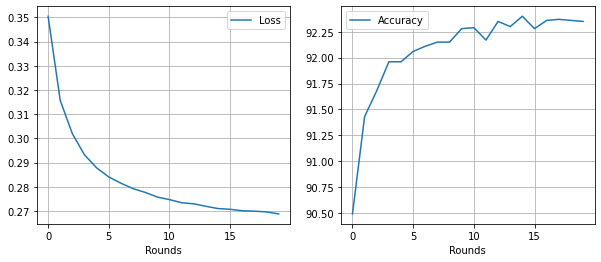

best set of exp2:  [92.4, 7, 20]


In [13]:
seed = 1228
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

args.exp_name = 'exp2'

#args.num_epochs = 5     #####
#args.num_rounds = 30    #####
args.num_clients = 3
args.lr = exp1_best_set[1]

args.batch_size = 100

args.NET_PATH = ''
args.INIT_PATH = f'FL_model/client = {args.num_clients}/initialize_weight.pth'



name_var1 = 'num_epochs'
name_var2 = 'num_rounds'
list_var1 = [3, 5, 7]
list_var2 = [10, 15 ,20]

exp2_best_set = [0, 0, 0]

train_set_list = data_split(args)
partition = {'train':train_set_list, 'test':test_dataset}

for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)

        print(f"{name_var1}:{var1} | {name_var2}:{var2}")

        round_loss, round_acc, round_list, param_data = experiment(partition, args)
        plot_loss(round_loss, round_acc)

        if max(round_acc) > exp2_best_set[0]:
            exp2_best_set[0] = max(round_acc)
            exp2_best_set[1] = var1
            exp2_best_set[2] = var2

print('best set of exp2: ', exp2_best_set)

### **Example 3 : *num_clients***

num_clients:3
[Round 0]  Round Loss: 0.35096306875348093  Round Acc: 90.55
[Round 1]  Round Loss: 0.31617341578006747  Round Acc: 91.38
[Round 2]  Round Loss: 0.30177342787384986  Round Acc: 91.67
[Round 3]  Round Loss: 0.2932292027771473  Round Acc: 91.77
[Round 4]  Round Loss: 0.28798549249768257  Round Acc: 92.01
[Round 5]  Round Loss: 0.28436535023152826  Round Acc: 92.06
[Round 6]  Round Loss: 0.281308803409338  Round Acc: 92.17
[Round 7]  Round Loss: 0.2790056362748146  Round Acc: 92.21
[Round 8]  Round Loss: 0.277645168453455  Round Acc: 92.24
[Round 9]  Round Loss: 0.27635802172124385  Round Acc: 92.25
[Round 10]  Round Loss: 0.27498217090964316  Round Acc: 92.24
[Round 11]  Round Loss: 0.274232779443264  Round Acc: 92.27
[Round 12]  Round Loss: 0.2735525116324425  Round Acc: 92.28
[Round 13]  Round Loss: 0.27251102790236476  Round Acc: 92.29
[Round 14]  Round Loss: 0.27136461302638054  Round Acc: 92.30
[Round 15]  Round Loss: 0.2707522831857204  Round Acc: 92.36
[Round 16]  Ro

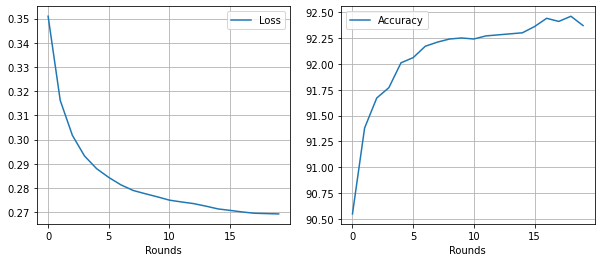

num_clients:5
[Round 0]  Round Loss: 0.3876043343544006  Round Acc: 89.81
[Round 1]  Round Loss: 0.3406998431682587  Round Acc: 90.75
[Round 2]  Round Loss: 0.3205928465723991  Round Acc: 91.21
[Round 3]  Round Loss: 0.3094245883822441  Round Acc: 91.55
[Round 4]  Round Loss: 0.30193174436688425  Round Acc: 91.75
[Round 5]  Round Loss: 0.2967403730750084  Round Acc: 91.82
[Round 6]  Round Loss: 0.29231584623456003  Round Acc: 91.86
[Round 7]  Round Loss: 0.2892718917131424  Round Acc: 91.96
[Round 8]  Round Loss: 0.2866530083864927  Round Acc: 92.06
[Round 9]  Round Loss: 0.2842821529507637  Round Acc: 92.05
[Round 10]  Round Loss: 0.28247237831354144  Round Acc: 92.09
[Round 11]  Round Loss: 0.2810650676488876  Round Acc: 92.10
[Round 12]  Round Loss: 0.27978598907589913  Round Acc: 92.17
[Round 13]  Round Loss: 0.27838233307003973  Round Acc: 92.20
[Round 14]  Round Loss: 0.27749779939651487  Round Acc: 92.29
[Round 15]  Round Loss: 0.27670241631567477  Round Acc: 92.26
[Round 16]  R

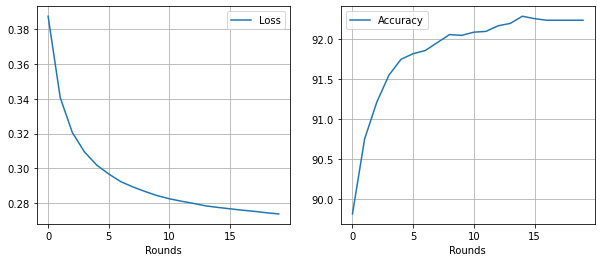

num_clients:8
[Round 0]  Round Loss: 0.43282307535409925  Round Acc: 88.91
[Round 1]  Round Loss: 0.37041881516575814  Round Acc: 90.09
[Round 2]  Round Loss: 0.3443221525847912  Round Acc: 90.66
[Round 3]  Round Loss: 0.32899063199758527  Round Acc: 90.97
[Round 4]  Round Loss: 0.3187077406048775  Round Acc: 91.28
[Round 5]  Round Loss: 0.3116197493672371  Round Acc: 91.54
[Round 6]  Round Loss: 0.3059671427309513  Round Acc: 91.59
[Round 7]  Round Loss: 0.30177695736289023  Round Acc: 91.67
[Round 8]  Round Loss: 0.29810708850622175  Round Acc: 91.77
[Round 9]  Round Loss: 0.29516288459300993  Round Acc: 91.87
[Round 10]  Round Loss: 0.29242879077792167  Round Acc: 91.84
[Round 11]  Round Loss: 0.29049583435058596  Round Acc: 91.93
[Round 12]  Round Loss: 0.28855829894542695  Round Acc: 91.98
[Round 13]  Round Loss: 0.28692600056529044  Round Acc: 92.01
[Round 14]  Round Loss: 0.28532389387488366  Round Acc: 92.05
[Round 15]  Round Loss: 0.28406475007534027  Round Acc: 92.06
[Round 1

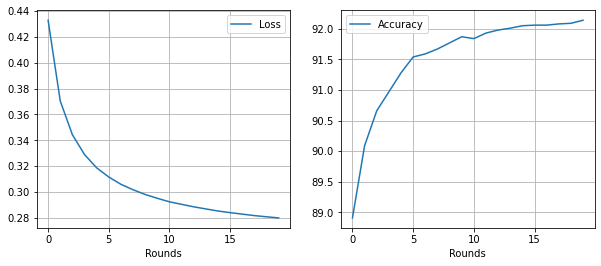

best set of exp3:  [92.46, 3]


In [15]:
seed = 1228
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

args.exp_name = 'exp3'

args.num_epochs = exp2_best_set[1]
args.num_rounds = exp2_best_set[2]
args.num_clients = 8
args.lr = exp1_best_set[1]

args.batch_size = 100

args.NET_PATH = ''
args.INIT_PATH = f'FL_model/client = {args.num_clients}/initialize_weight.pth'



name_var = 'num_clients'
list_var = [3, 5, 8]

exp3_best_set = [0, 0]

for var in list_var:
    setattr(args, name_var, var)

    train_set_list = data_split(args)
    partition = {'train':train_set_list, 'test':test_dataset}

    print(f"{name_var}:{var}")
    
    round_loss, round_acc, round_list, param_data = experiment(partition, args)
    plot_loss(round_loss, round_acc)

    if max(round_acc) > exp3_best_set[0]:
        exp3_best_set[0] = max(round_acc)
        exp3_best_set[1] = var

print('best set of exp3: ', exp3_best_set)

### **Final**

[Round 0]  Round Loss: 0.35096306875348093  Round Acc: 90.55
[Round 1]  Round Loss: 0.31617341578006747  Round Acc: 91.38
[Round 2]  Round Loss: 0.30177342787384986  Round Acc: 91.67
[Round 3]  Round Loss: 0.2932292027771473  Round Acc: 91.77
[Round 4]  Round Loss: 0.28798549249768257  Round Acc: 92.01
[Round 5]  Round Loss: 0.28436535023152826  Round Acc: 92.06
[Round 6]  Round Loss: 0.281308803409338  Round Acc: 92.17
[Round 7]  Round Loss: 0.2790056362748146  Round Acc: 92.21
[Round 8]  Round Loss: 0.277645168453455  Round Acc: 92.24
[Round 9]  Round Loss: 0.27635802172124385  Round Acc: 92.25
[Round 10]  Round Loss: 0.27498217090964316  Round Acc: 92.24
[Round 11]  Round Loss: 0.274232779443264  Round Acc: 92.27
[Round 12]  Round Loss: 0.2735525116324425  Round Acc: 92.28
[Round 13]  Round Loss: 0.27251102790236476  Round Acc: 92.29
[Round 14]  Round Loss: 0.27136461302638054  Round Acc: 92.30
[Round 15]  Round Loss: 0.2707522831857204  Round Acc: 92.36
[Round 16]  Round Loss: 0.27

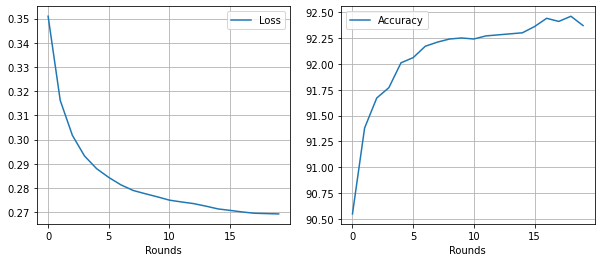

In [16]:
seed = 1228
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

args.exp_name = 'final'

args.num_epochs = exp2_best_set[1]
args.num_rounds = exp2_best_set[2]
args.num_clients = exp3_best_set[1]
args.lr = exp1_best_set[1]

args.batch_size = 100

args.NET_PATH = ''
args.INIT_PATH = f'Final/initialize_weight.pth'


train_set_list = data_split(args)
partition = {'train':train_set_list, 'test':test_dataset}
round_loss, round_acc, round_list, param_data = experiment(partition, args)
save_param(param_data)
#save_param_with_round(param_data)
plot_loss(round_loss, round_acc)

In [18]:
print(exp1_best_set)    #lr
print(exp2_best_set)    #epochs, rounds
print(exp3_best_set)    #clients

[92.54, 0.01]
[92.4, 7, 20]
[92.46, 3]


### **Final (save with rounds)**

In [14]:
seed = 1228
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

args.exp_name = 'final'

args.num_epochs = 5
args.num_rounds = 1000
args.num_clients = 3
args.lr = 0.001

args.batch_size = 100

args.NET_PATH = ''
args.INIT_PATH = f'Final/initialize_weight.pth'


train_set_list = data_split(args)
partition = {'train':train_set_list, 'test':test_dataset}
round_loss, round_acc, round_list, param_data = experiment(partition, args)
save_param_with_round(param_data, round_list, args)
plot_loss(round_loss, round_acc)

[Round 0]  Round Loss: 0.7729703968763352  Round Acc: 84.93
[Round 1]  Round Loss: 0.5853345933556556  Round Acc: 87.08
[Round 2]  Round Loss: 0.509514539539814  Round Acc: 88.00
[Round 3]  Round Loss: 0.46692598223686216  Round Acc: 88.48
[Round 4]  Round Loss: 0.438996339738369  Round Acc: 88.98
[Round 5]  Round Loss: 0.41905744969844816  Round Acc: 89.34
[Round 6]  Round Loss: 0.4038565507531166  Round Acc: 89.51
[Round 7]  Round Loss: 0.39186046585440637  Round Acc: 89.74
[Round 8]  Round Loss: 0.38206772521138194  Round Acc: 90.01
[Round 9]  Round Loss: 0.3739080484211445  Round Acc: 90.14
[Round 10]  Round Loss: 0.3669442674517632  Round Acc: 90.20
[Round 11]  Round Loss: 0.36086098328232763  Round Acc: 90.34
[Round 12]  Round Loss: 0.3556696791946888  Round Acc: 90.55
[Round 13]  Round Loss: 0.35102327063679695  Round Acc: 90.63
[Round 14]  Round Loss: 0.34680620789527894  Round Acc: 90.71
[Round 15]  Round Loss: 0.34315633311867716  Round Acc: 90.78
[Round 16]  Round Loss: 0.33

OSError: Cannot save file into a non-existent directory: 'Final\parameter_data'

finished save


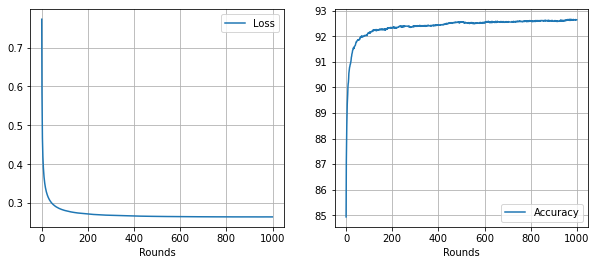

In [16]:
save_param_with_round(param_data, round_list, args)
plot_loss(round_loss, round_acc)